## Example

In this simple example, we load an image, pre-process it, and classify it with a pretrained EfficientNet.

In [1]:
import json
from PIL import Image

import torch
from torchvision import transforms
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from efficientnet_pytorch import EfficientNet

In [2]:
model_name = 'efficientnet-b0'
image_size = EfficientNet.get_image_size(model_name) # 224

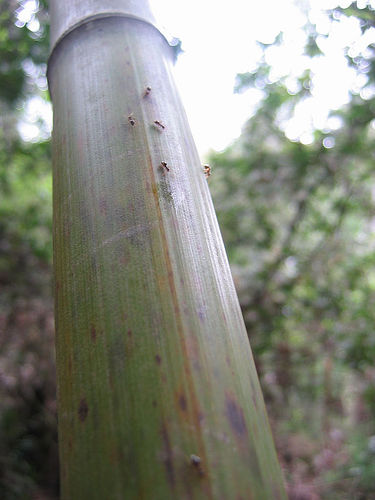

In [13]:
# Open image
img = Image.open('./hymenoptera_data/hymenoptera_data/val/ants/8124241_36b290d372.jpg')
img

In [14]:
# 前処理まとめ
tfms = transforms.Compose([transforms.Resize(image_size),
                           transforms.CenterCrop(image_size), 
                           transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                           ])
img = tfms(img).unsqueeze(0)

In [15]:
# Load class names
labels_map = json.load(open("ants_bee_labels.txt"))
labels_map = [labels_map[str(i)] for i in range(2)]
print(labels_map)

['ants', 'bees']


In [16]:
data_dir = "./hymenoptera_data/hymenoptera_data"
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x:  torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                          transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dataset_sizes)
print(class_names)
print(device)

{'train': 244, 'val': 153}
['ants', 'bees']
cpu


In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    print(was_training)
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Loaded pretrained weights for efficientnet-b0
Linear(in_features=1280, out_features=2, bias=True)
True


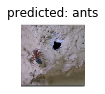

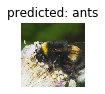

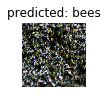

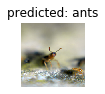

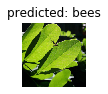

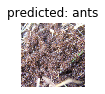

Epoch 0/24
----------


KeyboardInterrupt: 

In [12]:
import time
import os
import copy
import matplotlib.pyplot as plt
import numpy as np

# Classify with EfficientNet
model = EfficientNet.from_pretrained(model_name, num_classes=len(labels_map))
print(model._fc)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

visualize_model(model)
plt.ioff()
plt.show()

model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)
save_path = "test.pth"
torch.save(model.state_dict(),save_path) # 推奨される方 重みのみ
# torch.save(net,save_path) # モデル込で保存 別環境で失敗するかも
print("Saved model to " + save_path)

model.eval()
with torch.no_grad():
    logits = model(img)
preds = torch.topk(logits, k=5).indices.squeeze(0).tolist()

print('-----')
for idx in preds:
    label = labels_map[idx]
    prob = torch.softmax(logits, dim=1)[0, idx].item()
    print('{:<75} ({:.2f}%)'.format(label, prob*100))